## ProphetでCOVID-19の時系列解析を行う

In [1]:
# ライブラリーのインポート
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline

# 日本語化対応
import japanize_matplotlib
sns.set(font="IPAexGothic")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 全国感染者数を取得（厚生労働省が公開）
df = pd.read_csv('https://www.mhlw.go.jp/content/pcr_positive_daily.csv', index_col=0).iloc[:,:1]
df

,PCR 検査陽性者数(単日)
日付,
2020/1/16,1
2020/1/17,0
2020/1/18,0
2020/1/19,0
2020/1/20,0
...,...
2021/5/10,4925
2021/5/11,6238
2021/5/12,7057


In [3]:
# 全国検査数を取得（厚生労働省が公開）
df_test = pd.read_csv('https://www.mhlw.go.jp/content/pcr_tested_daily.csv', index_col=0).iloc[:,:1]
df_test

,PCR 検査実施件数(単日)
日付,
2020/2/5,4
2020/2/6,19
2020/2/7,9
2020/2/8,4
2020/2/9,10
...,...
2021/5/10,130677
2021/5/11,97038
2021/5/12,87073


<AxesSubplot:xlabel='日付'>

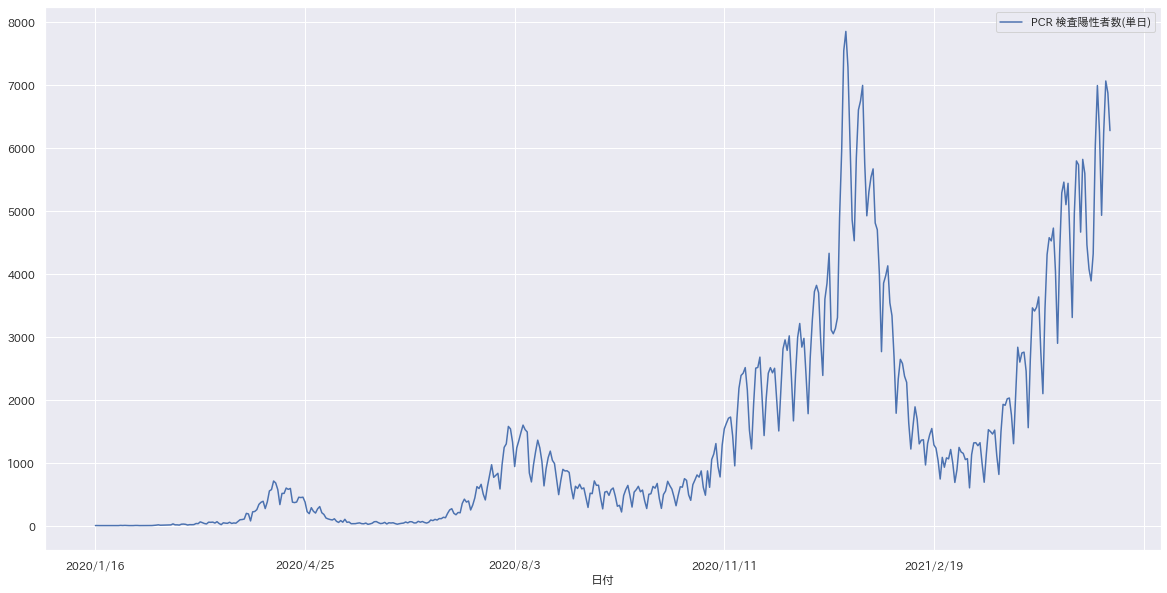

In [4]:
df.plot(figsize=(20,10))

In [5]:
# Prophet用にデータのカラム名を変更, 型の修正
df = df.reset_index()
df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"])
df

,ds,y
0,2020-01-16,1
1,2020-01-17,0
2,2020-01-18,0
3,2020-01-19,0
4,2020-01-20,0
...,...,...
480,2021-05-10,4925
481,2021-05-11,6238
482,2021-05-12,7057
483,2021-05-13,6867


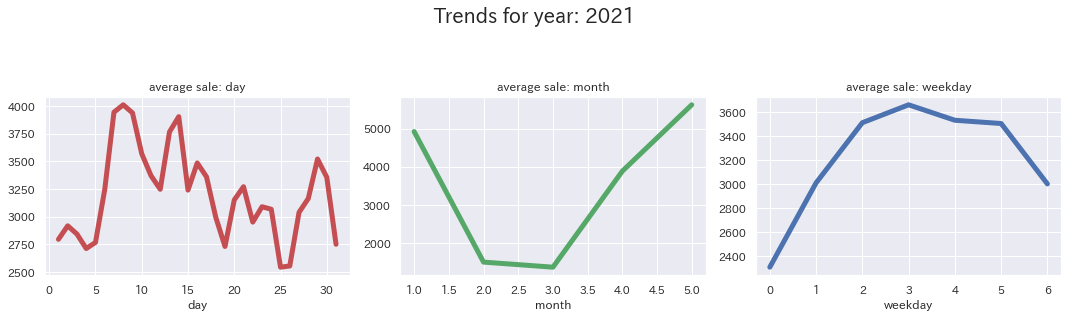

In [6]:
df['month'] = df.ds.apply(lambda x: x.month)
df['year'] = df.ds.apply(lambda x: x.year)
df['day'] = df.ds.apply(lambda x: x.day)
df['weekday'] = df.ds.apply(lambda x: x.dayofweek)

# 対象年
i = 2021

example = df[df.year==i].copy()
example.sort_values('ds',inplace=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
example.groupby('day').mean()['y']\
    .plot(kind='line',
          title='average sale: day',
          lw=5,
          color='r',
          ax=ax1)

example.groupby('month').mean()['y'] \
    .plot(kind='line',
          title='average sale: month',
          lw=5,
          color='g',

          ax=ax2)

example.groupby('weekday').mean()['y'] \
    .plot(kind='line',
          lw=5,
          title='average sale: weekday',
          color='b',

          ax=ax3)

fig.suptitle('Trends for year: {0}'.format(i),
             size=20,
             y=1.1)
plt.tight_layout()
plt.show()

## Prophetでモデルを構築する

In [7]:
df = df.rename(columns={'Date':'ds','Sales':'y'})
df = df[['ds','y']]
df_train = df[df['ds'] < '2021-04-01']
df_test = df[df['ds'] >= '2021-04-01']

In [8]:
model = Prophet()
model.add_country_holidays(country_name='JP')
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=len(df_test))
forecast = model.predict(future)

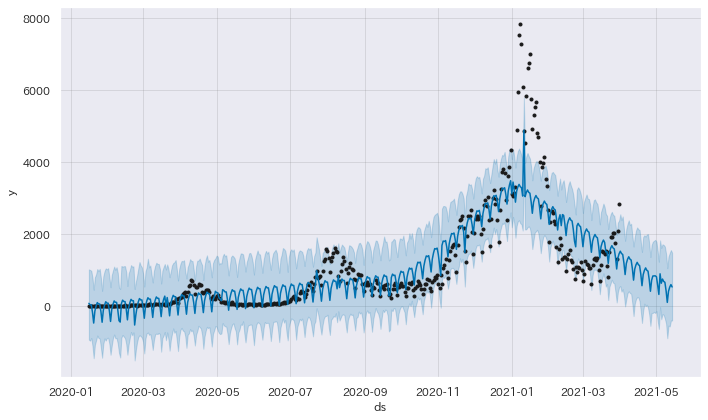

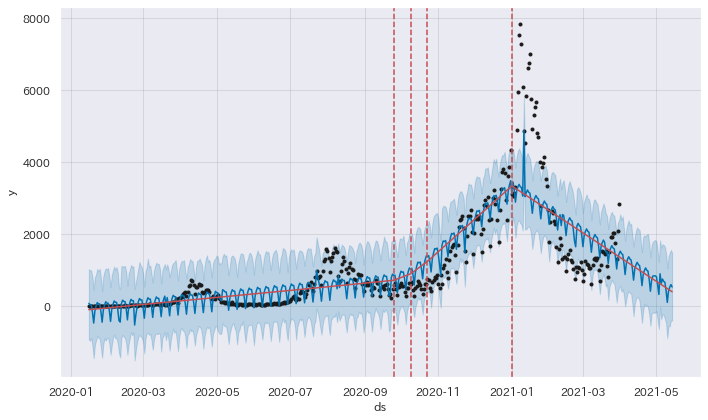

In [10]:
model.plot(forecast)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

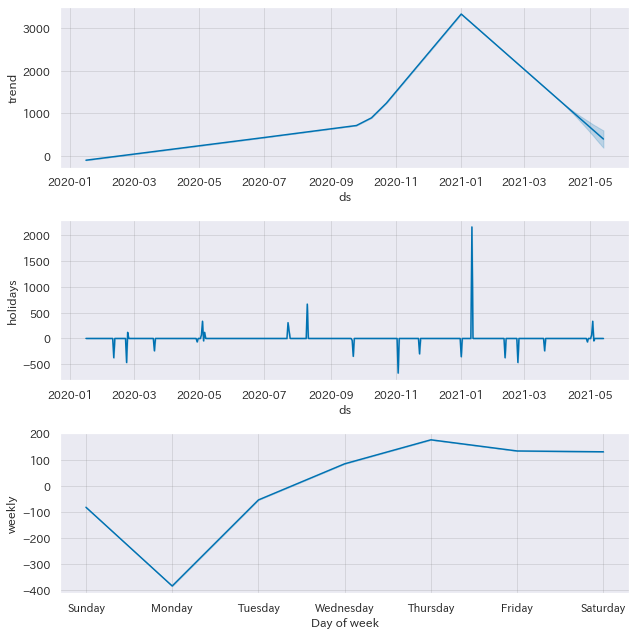

In [11]:
fig = model.plot_components(forecast)

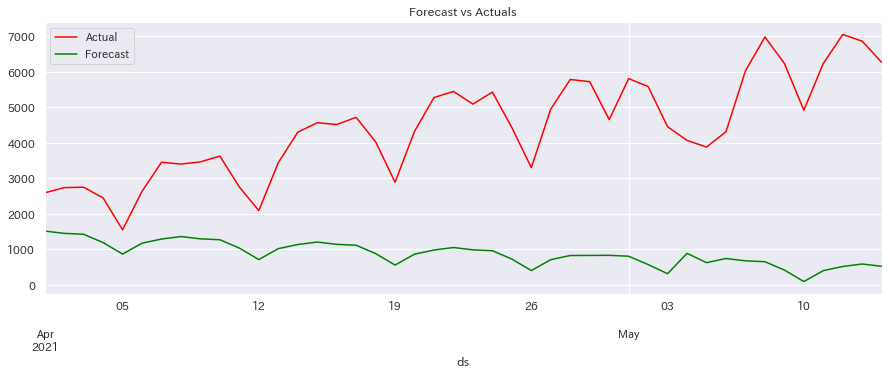

In [12]:
test_forecast = forecast.tail(len(df_test))
test_forecast.loc[test_forecast['yhat'] < 0, 'yhat'] = 0

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [13]:
# 評価指標
def _mape(true, pred):  
    """
    MAPEを計算する
    
    Args:
        true (np.array) : 実測値
        pred (np.array) : 予測値
    Returns:
        np.array        : mapeの計算結果
    
    """
    
    return np.mean(np.abs((true - pred) / true)) * 100


def _smape(true, pred):
    """
    SMAPEを計算する
    
    Args:
        true (np.array) : 実測値
        pred (np.array) : 予測値
    Returns:
        np.array        : smapeの計算結果
    
    """
    
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(pred) + np.abs(true)))


def eval_metric(true, pred):
    """
    各評価指標を計算する
    
    Args:
        true (np.array) : 実測値
        pred (np.array) : 予測値
    Returns:
        (pd.DataFrame)  :
            R2    : R2
            MAE   : MAE
            MSE   : MSE
            RMSE  : RMSE
            RMSLE : RMSLE
            MAPE  : MAPE
            SMAPE : SMAPE            
    
    """
    
    r2 = r2_score(true, pred)
    
    mae = mean_absolute_error(true, pred)
    
    mse = mean_squared_error(true, pred, squared=True)
    
    rmse = mean_squared_error(true, pred, squared=False)
    
    # RMSLEは、実測値<0 or 予測値<0 の場合は計算対象外とする
    rmsle_sample = (true >= 0) & (pred >= 0)
    
    # RMSLEの計算対象外のサンプルが一つも残らない場合はNaNを返す
    if rmsle_sample.sum() != 0:
        rmsle = np.sqrt(
            mean_squared_log_error(
                true[rmsle_sample], pred[rmsle_sample]
            )
        )
    else:
        rmsle = np.nan
    
    mape = _mape(true, pred)
    
    smape = _smape(true, pred)
    
    return pd.DataFrame(
        [[r2, mae, mse, rmse, rmsle, mape, smape]],
        columns=['R2', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'MAPE', 'SMAPE'],
    )

In [14]:
eval_metric(df_test.y, test_forecast.yhat)

,R2,MAE,MSE,RMSE,RMSLE,MAPE,SMAPE
0,-6.920436,3556.928608,1.512920e+07,3889.626726,1.800458,76.402097,127.907261
